# Comparison of the stability properties of the forward and backward Euler methods

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import cbmos
import cbmos.force_functions as ff
import cbmos.solvers.euler_forward as ef
import cbmos.solvers.euler_backward as eb
import cbmos.cell as cl

In [2]:
plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {
    'legend.fontsize': 'xx-large',
    'figure.figsize': (6.75, 5),
    'lines.linewidth': 3.0,
    'axes.labelsize': 'xx-large',
    'axes.titlesize':'xx-large',
    'xtick.labelsize':'xx-large',
    'ytick.labelsize':'xx-large',
    'legend.fontsize': 'xx-large',
    'font.size': 11,
    'font.family': 'serif',
    "mathtext.fontset": "dejavuserif",
    'axes.titlepad': 12,
    'axes.labelpad': 12,
}
plt.rcParams.update(params)

In [3]:
# Simulation parameters
s = 1.0    # rest length
tf = 1.0  # final time
rA = 1.5   # maximum interaction distance

seed=17

params_cubic = {
    "mu": 5.70,
    "s": s,
    "rA": rA,
}

muR = 9.1
ratio = 0.21
params_poly = {
    'muA': muR*ratio,
    'muR': muR,
    'rA': rA,
    'rR': 1.0/(1.0-np.sqrt(ratio)/3.0),
    'n': 1.0,
    'p': 1.0,
}

mu_gls = 1.95
params_gls = {
    'mu': mu_gls,
    'a': 7.51
}

params = {
    'cubic': params_cubic,
    'pw. quad.': params_poly,
    'GLS': params_gls
}

In [4]:
force_names = ['cubic', 'pw. quad.', 'GLS']


defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {
    'cubic': defcolors[0],
    'pw. quad.': defcolors[5],
    'GLS': defcolors[6],
}

In [5]:
solvers_ef = {
    'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), ef.solve_ivp, 1), 
    'cubic': cbmos.CBModel(ff.Cubic(), ef.solve_ivp, 1),
    'GLS': cbmos.CBModel(ff.Gls(), ef.solve_ivp, 1)
}
solvers_eb = {
    'pw. quad.': cbmos.CBModel(ff.PiecewisePolynomial(), eb.solve_ivp, 1), 
    'cubic': cbmos.CBModel(ff.Cubic(), eb.solve_ivp, 1),
    'GLS': cbmos.CBModel(ff.Gls(), eb.solve_ivp, 1)
}

We consider the relaxation of two daughter cells placed at a distance of 0.3 cell diameters after cell division.

In [6]:
# Initial condition
cell_list = [cl.Cell(0, [0]), cl.Cell(1, [0.3])]

In [7]:
dt_values = [0.005, 0.025, 0.075, 0.1, 0.125, 0.2]
N = [200,40, 15, 11, 8, 5]

Calculate the trajectories for different time step sizes for the forward Euler method...

In [8]:
sol_ef = {'cubic': [], 'pw. quad.': [], 'GLS': []}
for dt in dt_values:
    n = int(1/dt) + 1
    t_data = np.arange(0,1,dt)
    
    for force in force_names:
        (t, history) = solvers_ef[force].simulate(cell_list, t_data, params[force],
                                                  {'dt': dt}, seed=seed)
        y = np.array([np.abs(clt[1].position - clt[0].position) for clt in history])
        sol_ef[force].append(y)

...and the backward Euler method.

In [9]:
sol_eb = {'cubic': [], 'pw. quad.': [], 'GLS': []}
for dt in dt_values:
    n = int(1/dt) + 1
    t_data = np.arange(0,1,dt)
    
    for force in force_names:
        (t, history) = solvers_eb[force].simulate(
            cell_list, t_data, params[force],
            {'dt': dt, 'jacobian': solvers_eb[force].jacobian, 'force_args': params[force]}, seed=seed)
        y = np.array([np.abs(clt[1].position - clt[0].position) for clt in history])
        sol_eb[force].append(y)

In [10]:
linestyles = ['-', '--', ':']

Plot the results in a multipanel figure:

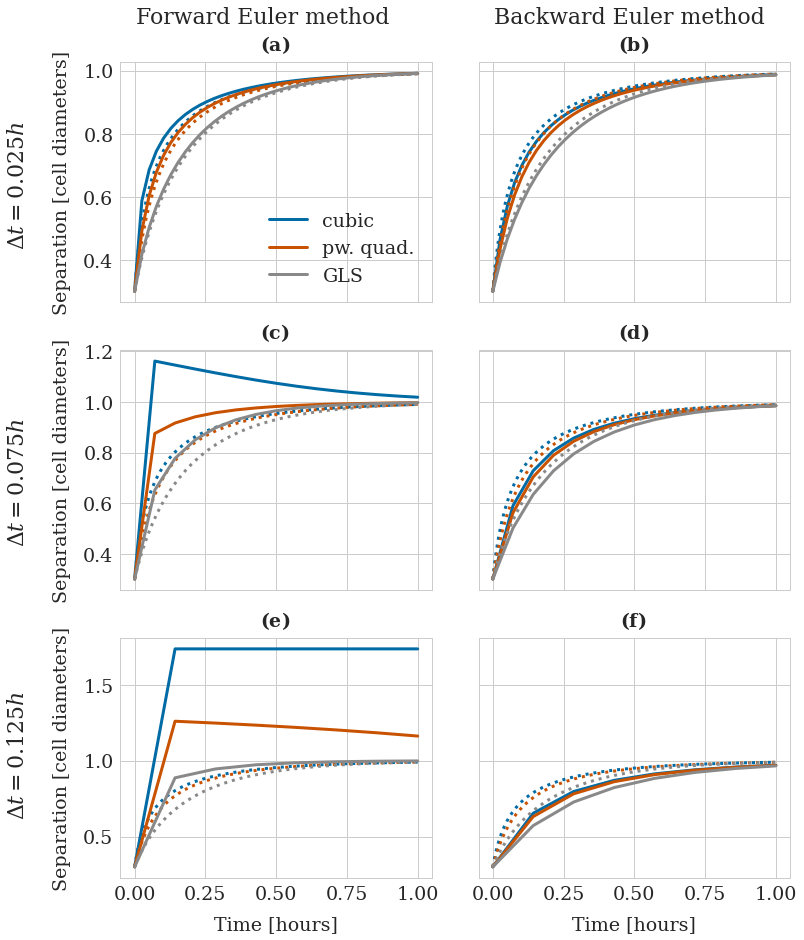

In [11]:
fig, ax = plt.subplots(3, 2, figsize=(12, 15), sharex=True, sharey='row',
                       gridspec_kw={'hspace':0.2, 'wspace': 0.15})

for k in range(3):
    offset = 2*k if k else 1
    for j, sol in enumerate([sol_ef, sol_eb]):
        dt = dt_values[k+1]
        for force in force_names: 
            ax[k, j].plot(np.linspace(0,tf,N[0]), sol[force][0],
                          color=colors[force], linestyle=linestyles[2])
            ax[k, j].plot(np.linspace(0,tf,N[offset]), sol[force][offset],
                          label=force, color=colors[force], linestyle=linestyles[0])
        ax[k, j].set(xlabel='Time [hours]',ylabel='Separation [cell diameters]')
        ax[k, j].set_title(r'$\bf{(' + chr(ord('a') + 2*k+j) + ')}$ ')
        ax[k, j].label_outer()

ax[0, 0].legend()
ax[0, 0].text(0.005, 1.15, 'Forward Euler method', fontsize=22)
ax[0, 1].text(0.005, 1.15, 'Backward Euler method', fontsize=22)
    
ax[0, 0].text(-0.45, 0.45, '$\Delta t = 0.025h$', fontsize=22, rotation='vertical')
ax[1, 0].text(-0.45, 0.45, '$\Delta t = 0.075h$', fontsize=22, rotation='vertical')
ax[2, 0].text(-0.45, 0.65, '$\Delta t = 0.125h$', fontsize=22, rotation='vertical')
     
plt.savefig('Figure3.pdf', bbox_inches='tight')
#plt.savefig('EF_overshoot.png', bbox_inches='tight')

We observe numerical instability for the forward Euler method when used with a too large time step (left column, panels (c) and (e)). The exact time step sizes that lead to physically incorrect or numerically unstable trajectories are force function dependend. The backward Euler method does not exhibit this issue (right column). 